# Project 1

*Evolved from Stanford Vision Lab. in the url " https://github.com/StanfordVL/CS131_release/blob/master/fall_2021/hw2_release/hw2.ipynb "*

*This notebook includes both coding and written questions. Please hand in this notebook file with all the outputs and your answers to the written questions.*

This assignment covers Sobel edge detector, Canny edge detector and Hough transform.

In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
from time import time
from skimage import io

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

##Part 1: Edge Detectors (50 Points)

In this part, you are going to implement Sobel and Canny edge detectors. In addition, you will compare the detectors visually.

### 1.1 Sobel Edge Detector (15 Points)
In this part, you are going to implement Sobel edge detector. The Sobel edge detection algorithm can be broken down in to three steps:

1. Convolving with Sobel-x filter
2. Convolving with Sobel-y filter
3. Finding gradients


#### 1.1.1 Convolving with Sobel-x filter (5 Points)

We first compute the sobel-x filter multiplying 1D Gaussian filter and x derivative. The equation can be given below:

$$\begin{align}
    s_x &= \begin{bmatrix}
           1 \\
           2 \\
           1
         \end{bmatrix} * \begin{bmatrix} 1 & 0 & -1
         \end{bmatrix}
  \end{align}$$


Implement **`conv`** and **`sobel_x`**.

In [36]:
def conv(image, kernel):
    """ An implementation of convolution filter.
    This function uses element-wise multiplication and np.sum()
    to efficiently compute weighted sum of neighborhood at each
    pixel.
    Args:
        image: numpy array of shape (Hi, Wi).
        kernel: numpy array of shape (Hk, Wk).
    Returns:
        out: numpy array of shape (Hi, Wi).
    """
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    out = np.zeros((Hi, Wi))

    # For this assignment, we will use edge values to pad the images.
    # Zero padding will make derivatives at the image boundary very big,
    # whereas we want to ignore the edges at the boundary.
    pad_width0 = Hk // 2
    pad_width1 = Wk // 2
    pad_width = ((pad_width0,pad_width0),(pad_width1,pad_width1))
    padded = np.pad(image, pad_width, mode='edge')

    ### YOUR CODE HERE
    out = np.zeros((Hi, Wi))
    for i in range(Hi):
        for j in range(Wi):
            # Extract the current patch from the padded image
            patch = padded[i:i+Hk, j:j+Wk]
            patch_times_kernel = np.multiply(patch, kernel)
            out[i, j] = np.sum(patch_times_kernel)

    ### END YOUR CODE
    return out

In [37]:
def sobel_x():
    """ Implementation of Sobel-x filter.
    This function follows the sobel-x formula,
    and creates a kernel matrix.
    Hints:
    - Use gaussian 1d kernel.
    Args:
    Returns:
        kernel: numpy array of shape (3, 3).
    """
    s_x = np.zeros((3, 3))

    ### YOUR CODE HERE
    # Define 1D Gaussian kernel and x-derivative kernel
    gaussian_1d = np.array([1, 2, 1]).reshape(-1, 1)
    x_derivative = np.array([1, 0,-1]).reshape(1, -1)
    s_x = np.outer(gaussian_1d, x_derivative)

    ### END YOUR CODE
    
    return s_x

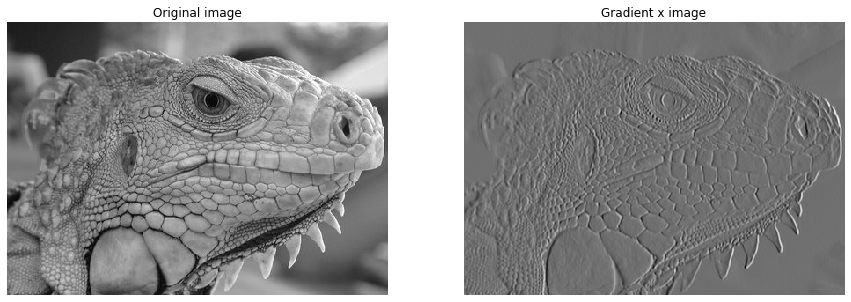

In [38]:
# Load image
img = io.imread('iguana.png', as_gray=True)

# Create sobel-x filter
kernel_x = sobel_x()

# Convolve the image with kernel
G_x = conv(img, kernel_x)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(G_x)
plt.title('Gradient x image')
plt.axis('off')

plt.show()

#### 1.1.2 Convolving with Sobel-y filter (5 Points)

We first compute the sobel-y filter multiplying y derivative and 1D Gaussian filter. The equation can be given below:

$$\begin{align}
    s_x &= \begin{bmatrix}
           -1 \\
           0 \\
           -1
         \end{bmatrix} * \begin{bmatrix} 1 & 2 & 1
         \end{bmatrix}
  \end{align}$$


Implement **`sobel_y`**.

In [40]:
def sobel_y():
    """ Implementation of Sobel-y filter.
    This function follows the sobel-y formula,
    and creates a kernel matrix.
    Hints:
    - Use gaussian 1d kernel.
    Args:
    Returns:
        kernel: numpy array of shape (3, 3).
    """
    s_y = np.zeros((3, 3))

    gaussian_1d = np.array([1,0,-1]).reshape(1, -1)
    y_derivative = np.array([1,2,1]).reshape(-1, 1)

    # Compute the 2D convolution of the two kernels
    s_y = np.outer(y_derivative, gaussian_1d)
    
    return s_y

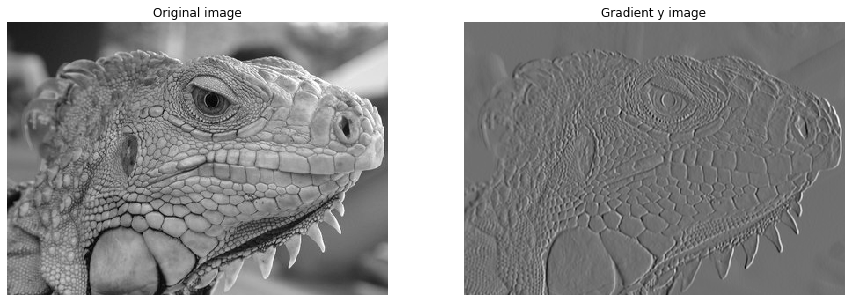

In [41]:
# Create sobel-y filter
kernel_y = sobel_y()

# Convolve the image with kernel
G_y = conv(img, kernel_y)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(G_y)
plt.title('Gradient y image')
plt.axis('off')

plt.show()

#### 1.1.3 Finding Gradient Magnitude (5 Points)

G_x denotes right direction that increases where G_y denotes down direction that increases. At each point in the image, the resulting gradient can be obtined to give the gradient magnitude and direction below:

$$G = \sqrt{G_{x}^{2} + G_{y}^{2}} \\ \theta = arctan2(\frac{G_y}{G_x})$$

Implement **`grad`**.

In [42]:
def grad(G_x, G_y):
    """ Returns gradient magnitude and direction of input image sobel gradients.
    Args:
        img: Gradient x and gradient y. Numpy array of shape (H, W).
    Returns:
        G: Magnitude of sobel gradient at each pixel in img.
            Numpy array of shape (H, W).
        theta: Direction(in degrees, 0 <= theta < 360) of sobel gradient
            at each pixel in img. Numpy array of shape (H, W).
    Hints:
        - Use np.sqrt and np.arctan2 to calculate square root and arctan
    """
    G = np.zeros(G_x.shape)
    theta = np.zeros(G_x.shape)

    # Compute the gradient magnitude and orientation
    G = np.sqrt(np.square(G_x) + np.square(G_y))
    theta = np.arctan2(G_y, G_x) * 180 / np.pi

    # Ensure theta is in the range [0, 360)
    theta = np.mod(theta, 360)

    return G, theta

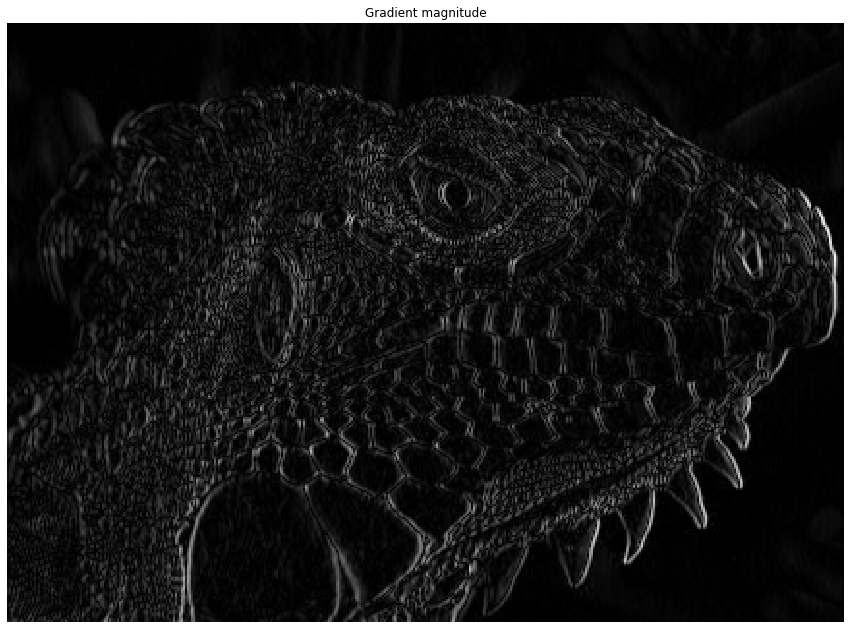

In [43]:
G, theta = grad(G_x, G_y)

if not np.all(G >= 0):
    print('Magnitude of gradients should be non-negative.')
    
if not np.all((theta >= 0) * (theta < 360)):
    print('Direction of gradients should be in range 0 <= theta < 360')

plt.imshow(G)
plt.title('Gradient magnitude')
plt.axis('off')
plt.show()

#### 1.1.4 Sobel Edge Detector

Implement sobel using the functions you have implemented so far.

In [44]:
def sobel(img):
    """ Implement sobel edge detector by calling functions above.
    Args:
        img: binary image of shape (H, W).
    Returns:
        edge: numpy array of shape(H, W).
    """
    H, W = img.shape
    edge = np.zeros((H, W), dtype=np.bool)
    kernel_x = sobel_x()
    kernel_y = sobel_y()

    G_x = conv(img, kernel_x)
    G_y = conv(img, kernel_y)

    # Compute the magnitude and direction of the gradient
    G = np.sqrt(np.square(G_x) + np.square(G_y))
    theta = (np.rad2deg(np.arctan2(G_y, G_x)) + 180) % 360

    # Threshold the gradient magnitude
    edge = G > 0.45

    return edge

C:\Users\gamze\AppData\Local\Temp\ipykernel_33412\4079988880.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  edge = np.zeros((H, W), dtype=np.bool)


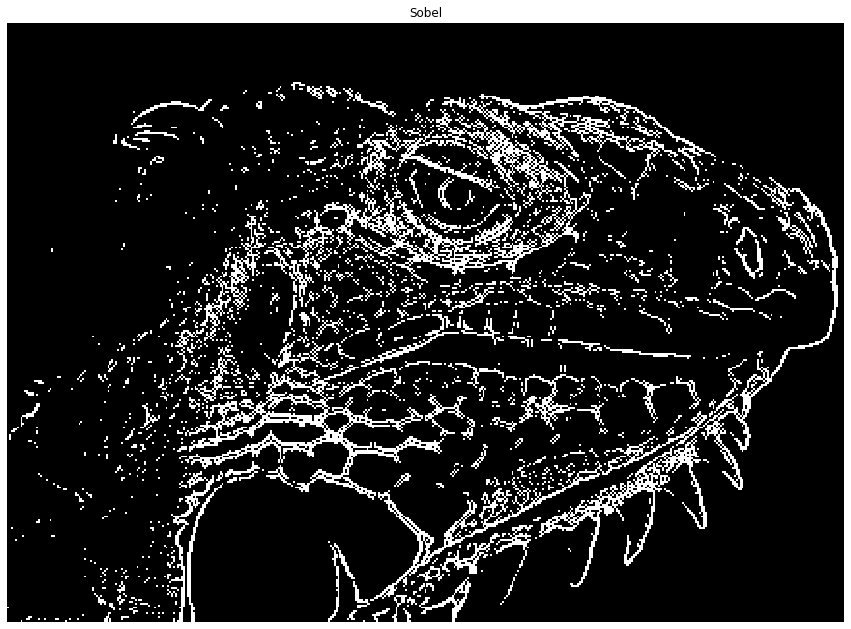

In [10]:
img = io.imread('iguana.png', as_gray=True)

edges = sobel(img)

plt.imshow(edges)
plt.title('Sobel')
plt.axis('off')
plt.show()

### 1.2 Canny Edge Detector (25 points)
In this part, you are going to implement Canny edge detector. The Canny edge detection algorithm can be broken down in to five steps:
1. Smoothing
2. Finding gradients
3. Non-maximum suppression
4. Double thresholding
5. Edge tracking by hysterisis

#### 1.2.1 Smoothing (5 points)
##### Implementation (2.5 points)
We first smooth the input image by convolving it with a Gaussian kernel. The equation for a Gaussian kernel of size $(2k+1)\times(2k+1)$ is given by:

$$h_{ij}=\frac{1}{2\pi\sigma^2}\exp{\Bigl(-\frac{(i-k)^2+(j-k)^2}{2\sigma^2}\Bigr)}, 0\leq i,j < 2k+1$$

Implement **`gaussian_kernel`** and run the code below.

In [11]:
def gaussian_kernel(size, sigma):
    """ Implementation of Gaussian Kernel.
    This function follows the gaussian kernel formula,
    and creates a kernel matrix.
    Hints:
    - Use np.pi and np.exp to compute pi and exp.
    Args:
        size: int of the size of output matrix.
        sigma: float of sigma to calculate kernel.
    Returns:
        kernel: numpy array of shape (size, size).
    """

    kernel = np.zeros((size, size))
    
    ### YOUR CODE HERE
    k = size // 2
    for i in range(size):
        for j in range(size):
            kernel[i, j] = (1 / (2 * np.pi * sigma**2)) * np.exp((-1) * ((i - k)**2 + (j - k)**2) / (2 * (sigma**2)))
    
    ### END YOUR CODE

    return kernel

In [12]:
# Define 3x3 Gaussian kernel with std = 1
kernel = gaussian_kernel(3, 1)
kernel_test = np.array(
    [[ 0.05854983, 0.09653235, 0.05854983],
     [ 0.09653235, 0.15915494, 0.09653235],
     [ 0.05854983, 0.09653235, 0.05854983]]
)

# Test Gaussian kernel
if not np.allclose(kernel, kernel_test):
    print('Incorrect values! Please check your implementation.')

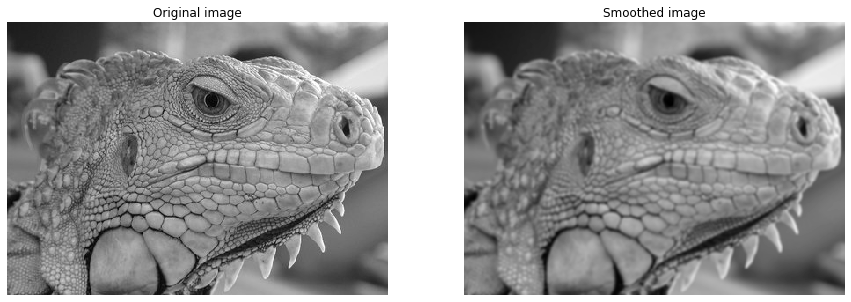

In [13]:
# Test with different kernel_size and sigma
kernel_size = 5
sigma = 1.4

# Load image
img = io.imread('iguana.png', as_gray=True)

# Define 5x5 Gaussian kernel with std = sigma
kernel = gaussian_kernel(kernel_size, sigma)

# Convolve image with kernel to achieve smoothed effect
smoothed = conv(img, kernel)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(smoothed)
plt.title('Smoothed image')
plt.axis('off')

plt.show()

##### Question (2.5 points)
What is the effect of the kernel_size and sigma?

**Your Answer:** A larger kernel size and sigma value will result in smoother edges with less noise, but may also reduce the sharpness and detail of the edges. Conversely, a smaller kernel size and sigma value will result in sharper and more detailed edges, but may also be more sensitive to noise in the image. Therefore, the optimal choice of kernel_size and sigma depends on the specific characteristics of the input image and the requirements of the edge detection task.

#### 1.2.2 Finding gradients (5 points)
The gradient of a 2D scalar function $I:\mathbb{R}^2\rightarrow{\mathbb{R}}$ in Cartesian coordinate is defined by:

$$\nabla{I(x,y)}=\bigl[\frac{\partial{I}}{\partial{x}},\frac{\partial{I}}{\partial{y}}\bigr],$$

where

$$
\frac{\partial{I(x,y)}}{\partial{x}}=\lim_{\Delta{x}\to{0}}\frac{I(x+\Delta{x},y)-I(x,y)}{\Delta{x}} \\
\frac{\partial{I(x,y)}}{\partial{y}}=\lim_{\Delta{y}\to{0}}\frac{I(x,y+\Delta{y})-I(x,y)}{\Delta{y}}.
$$

In case of images, we can approximate the partial derivatives by taking differences at one pixel intervals:

$$
\frac{\partial{I(x,y)}}{\partial{x}}\approx{\frac{I(x+1,y)-I(x-1,y)}{2}} \\
\frac{\partial{I(x,y)}}{\partial{y}}\approx{\frac{I(x,y+1)-I(x,y-1)}{2}}
$$

Note that the partial derivatives can be computed by convolving the image $I$ with some appropriate kernels $D_x$ and $D_y$:

$$
\frac{\partial{I}}{\partial{x}}\approx{I*D_x}=G_x \\
\frac{\partial{I}}{\partial{y}}\approx{I*D_y}=G_y
$$

##### Implementation (2 points)
Find the kernels $D_x$ and $D_y$ and implement **`partial_x`** and **`partial_y`** using `conv`.

*-Hint: Remeber that convolution flips the kernel.*

In [14]:
def partial_x(img):
    """ Computes partial x-derivative of input img.
    Hints:
        - You may use the conv function in defined in this file.
    Args:
        img: numpy array of shape (H, W).
    Returns:
        out: x-derivative image.
    """

    out = None

    ### YOUR CODE HERE
    kernel = np.array([[-1, 0, 1]]) / 2.0
    out = conv(img, kernel)
    ### END YOUR CODE

    return out

In [15]:
def partial_y(img):
    """ Computes partial y-derivative of input img.
    Hints:
        - You may use the conv function in defined in this file.
    Args:
        img: numpy array of shape (H, W).
    Returns:
        out: y-derivative image.
    """

    out = None

    ### YOUR CODE HERE
    kernel = 1./2 * np.array([[-1], [0], [1]])
    out = conv(img, kernel)
    ### END YOUR CODE

    return out

In [16]:
# Test input
I = np.array(
    [[0, 0, 0],
     [0, 1, 0],
     [0, 0, 0]]
)

# Expected outputs
I_x_test = np.array(
    [[ 0, 0, 0],
     [ 0.5, 0, -0.5],
     [ 0, 0, 0]]
)

I_y_test = np.array(
    [[ 0, 0.5, 0],
     [ 0, 0, 0],
     [ 0, -0.5, 0]]
)

# Compute partial derivatives
I_x = partial_x(I)
I_y = partial_y(I)

# Test correctness of partial_x and partial_y
if not np.all(I_x == I_x_test):
    print('partial_x incorrect')
    
if not np.all(I_y == I_y_test):
    print('partial_y incorrect')

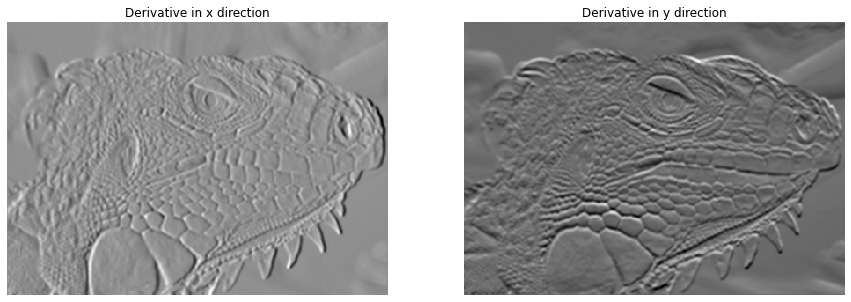

In [17]:
# Compute partial derivatives of smoothed image
Gx = partial_x(smoothed)
Gy = partial_y(smoothed)

plt.subplot(1,2,1)
plt.imshow(Gx)
plt.title('Derivative in x direction')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(Gy)
plt.title('Derivative in y direction')
plt.axis('off')

plt.show()

##### Question (1 points)
What is the reason for performing smoothing prior to computing the gradients?

**Your Answer:** Smoothing for reduce the effect of noise and minor fluctuations in the image. Averaging the values of the pixels in the near area of each pixel helps to achieve that.

##### Implementation (2 points)
Now, we can compute the magnitude and direction of gradient with the two partial derivatives:

$$
G = \sqrt{G_{x}^{2}+G_{y}^{2}} \\
\Theta = arctan\bigl(\frac{G_{y}}{G_{x}}\bigr)
$$

Implement **`gradient`** which takes in an image and outputs $G$ and $\Theta$.

*-Hint: Use np.arctan2 to compute $\Theta$.*

In [18]:
def gradient(img):
    """ Returns gradient magnitude and direction of input img.
    Args:
        img: Grayscale image. Numpy array of shape (H, W).
    Returns:
        G: Magnitude of gradient at each pixel in img.
            Numpy array of shape (H, W).
        theta: Direction(in degrees, 0 <= theta < 360) of gradient
            at each pixel in img. Numpy array of shape (H, W).
    Hints:
        - Use np.sqrt and np.arctan2 to calculate square root and arctan
    """
    G = np.zeros(img.shape)
    theta = np.zeros(img.shape)

    ### YOUR CODE HERE
    partial_x = conv(img, np.array([[1, 0, -1]])) / 2
    partial_y = conv(img, np.array([[1], [0], [-1]])) / 2
    G = np.sqrt(np.square(partial_x) + np.square(partial_y))
    theta = np.arctan2(partial_y, partial_x) * 180 / np.pi
    theta[theta < 0] += 360
    ### END YOUR CODE

    return G, theta

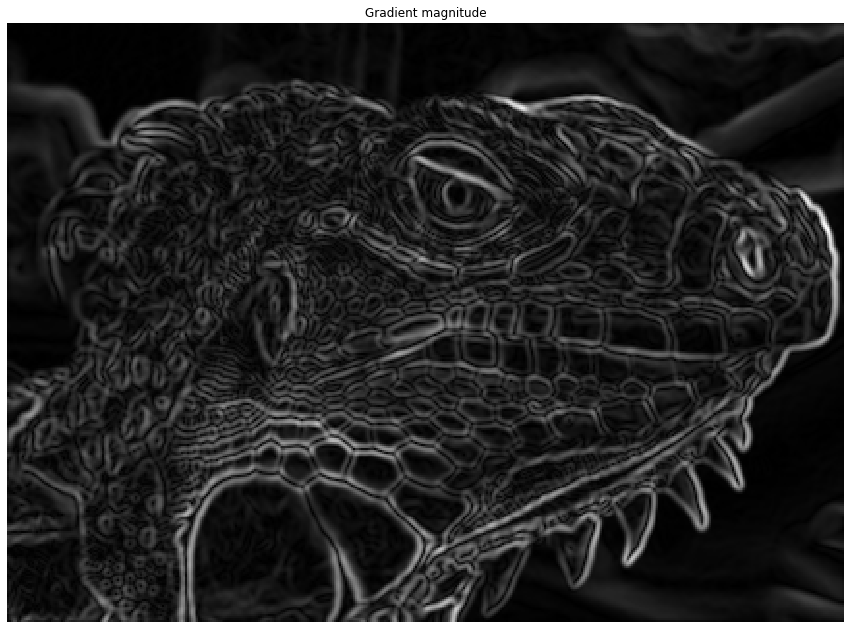

In [19]:
G, theta = gradient(smoothed)

if not np.all(G >= 0):
    print('Magnitude of gradients should be non-negative.')
    
if not np.all((theta >= 0) * (theta < 360)):
    print('Direction of gradients should be in range 0 <= theta < 360')

plt.imshow(G)
plt.title('Gradient magnitude')
plt.axis('off')
plt.show()

#### 1.2.3 Non-maximum suppression (5 points)
You should be able to note that the edges extracted from the gradient of the smoothed image is quite thick and blurry. The purpose of this step is to convert the "blurred" edges into "sharp" edges. Basically, this is done by preserving all local maxima in the gradient image and discarding everything else. The algorithm is for each pixel (x,y) in the gradient image:
1. Round the gradient direction $\Theta[y,x]$ to the nearest 45 degrees, corresponding to the use of an 8-connected neighbourhood.

2. Compare the edge strength of the current pixel with the edge strength of the pixel in the positive and negative gradient direction. For example, if the gradient direction is south (theta=90), compare with the pixels to the north and south.

3. If the edge strength of the current pixel is the largest; preserve the value of the edge strength. If not, suppress (i.e. remove) the value.

Implement **`non_maximum_suppression`**.

In [20]:
def non_maximum_suppression(G, theta):
    """ Performs non-maximum suppression.
    This function performs non-maximum suppression along the direction
    of gradient (theta) on the gradient magnitude image (G).
    Args:
        G: gradient magnitude image with shape of (H, W).
        theta: direction of gradients with shape of (H, W).
    Returns:
        out: non-maxima suppressed image.
    """
    H, W = G.shape
    out = np.zeros((H, W))

    # Round the gradient direction to the nearest 45 degrees
    theta = np.floor((theta + 22.5) / 45) * 45
    theta = (theta % 360.0).astype(np.int32)

    #print(G)
    ### BEGIN YOUR CODE
    for i in range(1, H-1):
        for j in range(1, W-1):
            current_angle = theta[i, j]

            # Define the neighbors based on the current angle
            if current_angle == 0 or current_angle == 180:
                neighbors = [G[i, j-1], G[i, j+1]]
            elif current_angle == 45 or current_angle == 225:
                neighbors = [G[i-1, j-1], G[i+1, j+1]]
            elif current_angle == 90 or current_angle == 270:
                neighbors = [G[i-1, j], G[i+1, j]]
            elif current_angle == 135 or current_angle == 315:
                neighbors = [G[i-1, j+1], G[i+1, j-1]]
            else:
                # Print an error message if the angle is invalid
                print("One of the theta values given is incorrect")

            # Check if the edge strength of the current pixel is the largest among the neighbors
            if G[i, j] >= np.max(neighbors):
                out[i, j] = G[i, j]  # Preserve the edge strength value
            else:
                out[i, j] = 0  # Suppress the edge strength value

    ### END YOUR CODE

    return out

In [21]:
# Test input
g = np.array(
    [[0.4, 0.5, 0.6],
     [0.3, 0.5, 0.7],
     [0.4, 0.5, 0.6]]
)

# Print out non-maximum suppressed output
# varying theta
for angle in range(0, 180, 45):
    print('Thetas:', angle)
    t = np.ones((3, 3)) * angle # Initialize theta
    print(non_maximum_suppression(g, t))

Thetas: 0
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Thetas: 45
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Thetas: 90
[[0.  0.  0. ]
 [0.  0.5 0. ]
 [0.  0.  0. ]]
Thetas: 135
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


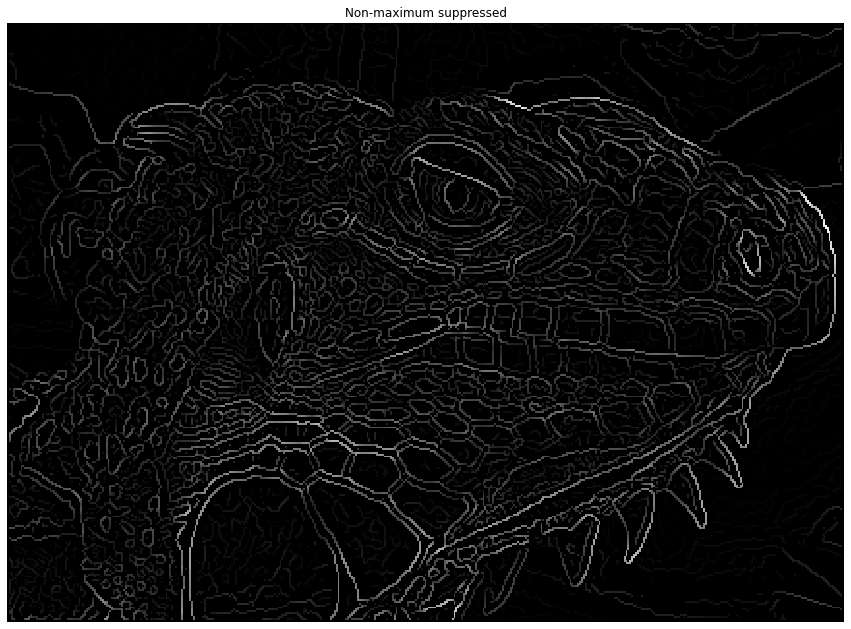

In [22]:
nms = non_maximum_suppression(G, theta)
plt.imshow(nms)
plt.title('Non-maximum suppressed')
plt.axis('off')
plt.show()

#### 1.2.4 Double Thresholding (5 points)

The edge-pixels remaining after the non-maximum suppression step are (still) marked with their strength pixel-by-pixel. Many of these will probably be true edges in the image, but some may be caused by noise or color variations, for instance, due to rough surfaces. The simplest way to discern between these would be to use a threshold, so that only edges stronger that a certain value would be preserved. The Canny edge detection algorithm uses double thresholding. Edge pixels stronger than the high threshold are marked as strong; edge pixels weaker than the low threshold are suppressed and edge pixels between the two thresholds are marked as weak.

Implement **`double_thresholding`**.

In [23]:
def double_thresholding(img, high, low):
    """
    Args:
        img: numpy array of shape (H, W) representing NMS edge response.
        high: high threshold(float) for strong edges.
        low: low threshold(float) for weak edges.
    Returns:
        strong_edges: Boolean array representing strong edges.
            Strong edeges are the pixels with the values greater than
            the higher threshold.
        weak_edges: Boolean array representing weak edges.
            Weak edges are the pixels with the values smaller or equal to the
            higher threshold and greater than the lower threshold.
    """

    strong_edges = np.zeros(img.shape, dtype=np.bool)
    weak_edges = np.zeros(img.shape, dtype=np.bool)

    ### YOUR CODE HERE
    #low, high = np.percentile(img, [0.05* 100, 0.15 * 100])

    # Determine strong and weak edges
    strong_edges = img > high
    weak_edges = (img <= high) & (img > low)
    ### END YOUR CODE

    return strong_edges, weak_edges

C:\Users\gamze\AppData\Local\Temp\ipykernel_33412\2305758478.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  strong_edges = np.zeros(img.shape, dtype=np.bool)
C:\Users\gamze\AppData\Local\Temp\ipykernel_33412\2305758478.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  weak_edges = np.zeros(img.shape, dtype=np.bool)


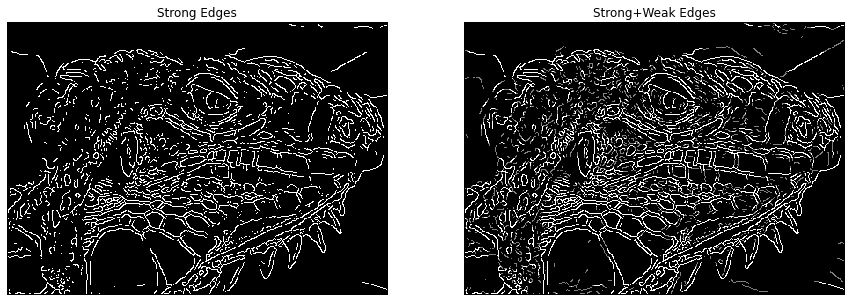

In [24]:
low_threshold = 0.02
high_threshold = 0.03

strong_edges, weak_edges = double_thresholding(nms, high_threshold, low_threshold)
assert(np.sum(strong_edges & weak_edges) == 0)

edges=strong_edges * 1.0 + weak_edges * 0.5

plt.subplot(1,2,1)
plt.imshow(strong_edges)
plt.title('Strong Edges')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(edges)
plt.title('Strong+Weak Edges')
plt.axis('off')

plt.show()

#### 1.2.5 Edge tracking (5 points)

Strong edges are interpreted as “certain edges”, and can immediately be included in the final edge image. Weak edges are included if and only if they are connected to strong edges. The logic is of course that noise and other small variations are unlikely to result in a strong edge (with proper adjustment of the threshold levels). Thus strong edges will (almost) only be due to true edges in the original image. The weak edges can either be due to true edges or noise/color variations. The latter type will probably be distributed in dependently of edges on the entire image, and thus only a small amount will be located adjacent to strong edges. Weak edges due to true edges are much more likely to be connected directly to strong edges.

Implement **`link_edges`**.

In [25]:
def get_neighbors(y, x, H, W):
    """ Return indices of valid neighbors of (y, x).
    Return indices of all the valid neighbors of (y, x) in an array of
    shape (H, W). An index (i, j) of a valid neighbor should satisfy
    the following:
        1. i >= 0 and i < H
        2. j >= 0 and j < W
        3. (i, j) != (y, x)
    Args:
        y, x: location of the pixel.
        H, W: size of the image.
    Returns:
        neighbors: list of indices of neighboring pixels [(i, j)].
    """
    neighbors = []

    for i in (y-1, y, y+1):
        for j in (x-1, x, x+1):
            if i >= 0 and i < H and j >= 0 and j < W:
                if (i == y and j == x):
                    continue
                neighbors.append((i, j))

    return neighbors

In [26]:
def link_edges(strong_edges, weak_edges):
    """ Find weak edges connected to strong edges and link them.
    Iterate over each pixel in strong_edges and perform breadth first
    search across the connected pixels in weak_edges to link them.
    Here we consider a pixel (a, b) is connected to a pixel (c, d)
    if (a, b) is one of the eight neighboring pixels of (c, d).
    Args:
        strong_edges: binary image of shape (H, W).
        weak_edges: binary image of shape (H, W).
    
    Returns:
        edges: numpy boolean array of shape(H, W).
    """

    H, W = strong_edges.shape
    indices = np.stack(np.nonzero(strong_edges)).T
    edges = np.zeros((H, W), dtype=np.bool)

    # Make new instances of arguments to leave the original
    # references intact
    weak_edges = np.copy(weak_edges)
    edges = np.copy(strong_edges)

    ### YOUR CODE HERE
    indices_to_visit = [(0, 0)]

    visited_indices = np.zeros_like(edges)

    while indices_to_visit:
        row, column = indices_to_visit.pop(0)

        if visited_indices[row, column] == 1:
            continue

        visited_indices[row, column] = 1

        neighbors = get_neighbors(row, column, H, W)

        for x, y in neighbors:
            indices_to_visit.append((x, y))

        neighbor_edges = any(edges[x, y] for x, y in neighbors)

        if weak_edges[row, column] and neighbor_edges:
            edges[row, column] = 1

    ### END YOUR CODE

    return edges

C:\Users\gamze\AppData\Local\Temp\ipykernel_33412\4265970105.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  edges = np.zeros((H, W), dtype=np.bool)


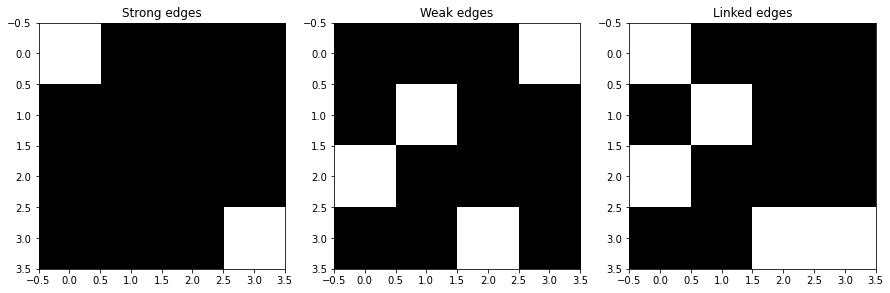

In [27]:
test_strong = np.array(
    [[1, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 1]]
)

test_weak = np.array(
    [[0, 0, 0, 1],
     [0, 1, 0, 0],
     [1, 0, 0, 0],
     [0, 0, 1, 0]]
)

test_linked = link_edges(test_strong, test_weak)

plt.subplot(1, 3, 1)
plt.imshow(test_strong)
plt.title('Strong edges')

plt.subplot(1, 3, 2)
plt.imshow(test_weak)
plt.title('Weak edges')

plt.subplot(1, 3, 3)
plt.imshow(test_linked)
plt.title('Linked edges')
plt.show()

C:\Users\gamze\AppData\Local\Temp\ipykernel_33412\4265970105.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  edges = np.zeros((H, W), dtype=np.bool)


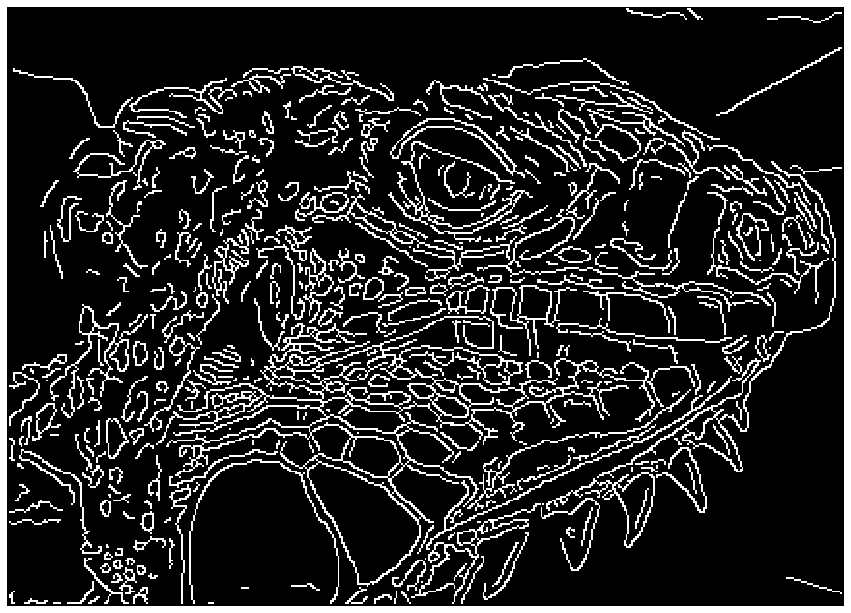

In [28]:
edges = link_edges(strong_edges, weak_edges)

plt.imshow(edges)
plt.axis('off')
plt.show()

### 1.6 Canny edge detector
Implement **`canny`** using the functions you have implemented so far. Test edge detector with different parameters.

Here is an example of the output:

<img src="iguana_edges.png" width="400">

In [29]:
def canny(img, kernel_size=5, sigma=1.4, high=20, low=15):
    """ Implement canny edge detector by calling functions above.
    Args:
        img: binary image of shape (H, W).
        kernel_size: int of size for kernel matrix.
        sigma: float for calculating kernel.
        high: high threshold for strong edges.
        low: low threashold for weak edges.
    Returns:
        edge: numpy array of shape(H, W).
    """
    H, W = img.shape
    edge = np.zeros((H, W), dtype=np.bool)
    ### YOUR CODE HERE
        # Apply a Gaussian blur to the image
    img = conv(img, gaussian_kernel(kernel_size, sigma))

    # Calculate the image gradient using the Sobel operator
    G, theta = gradient(img)

    # Perform non-maximum suppression to thin out the edges
    nms = non_maximum_suppression(G, theta)

    # Perform double thresholding to classify edges as strong or weak
    strong_edges, weak_edges = double_thresholding(nms, high, low)

    # Link weak edges to strong edges using edge following
    edge = link_edges(strong_edges, weak_edges)

    ### END YOUR CODE

    return edge

C:\Users\gamze\AppData\Local\Temp\ipykernel_33412\268959475.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  edge = np.zeros((H, W), dtype=np.bool)
C:\Users\gamze\AppData\Local\Temp\ipykernel_33412\2305758478.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  strong_edges = np.zeros(img.shape, dtype=np.bool)
C:\Users\gamze\AppData\Local\Temp\

(310, 433)


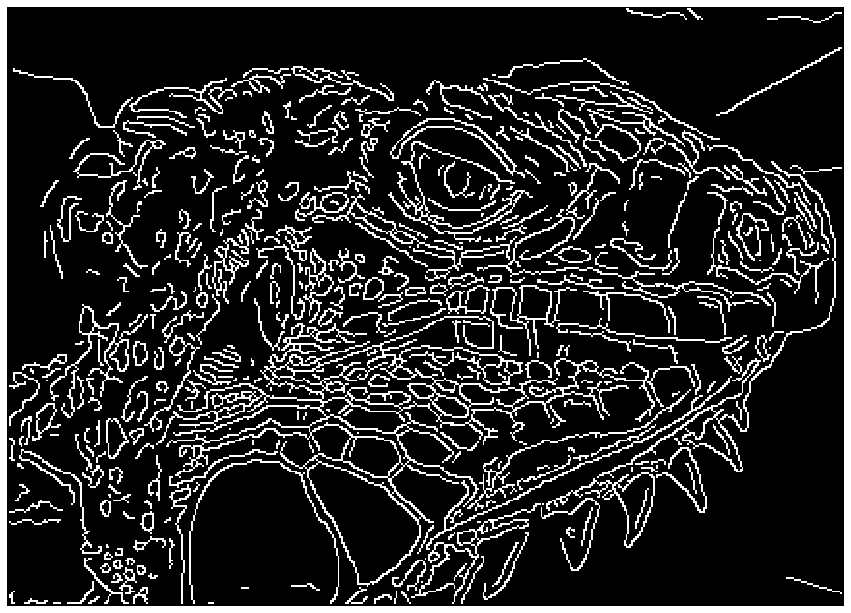

In [30]:
# Load image
img = io.imread('iguana.png', as_gray=True)

# Run Canny edge detector
edges = canny(img, kernel_size=5, sigma=1.4, high=0.03, low=0.02)
print (edges.shape)
plt.imshow(edges)
plt.axis('off')
plt.show()

#### 1.2.7 Question (10 points)

<img src="1.7a.png" width="400">

**(a)** Suppose that the Canny edge detector successfully detects an edge in an image. The edge (see the figure above) is then rotated by θ, where the relationship between a point on the original edge $(x, y)$ and a point on the rotated edge $(x', y')$ is defined as

$$
x'=x\cos{\theta}\\
y'=x\sin{\theta}
$$

Will the rotated edge be detected using the same Canny edge detector? Provide either a mathematical proof or a counter example.

*-Hint: The detection of an edge by the Canny edge detector depends only on the magnitude of its derivative. The derivative at point (x, y) is determined by its components along the x and y directions. Think about how these magnitudes have changed because of the rotation.*

**Your Answer:** The Canny edge detector is a widely used algorithm for detecting edges in images. However, it is important to note that an edge that is detected by the Canny edge detector may not necessarily be detected when the same edge is rotated by an angle of θ. This is because the magnitude and direction of the derivative changes depending on the orientation of the edge with respect to the direction of the derivative.

For instance, if the edge is perpendicular to the direction of the derivative, the magnitude of the derivative remains the same. However, if the edge is oblique to the direction of the derivative, the magnitude of the derivative decreases. Moreover, if the edge is parallel to the direction of the derivative, the magnitude of the derivative is zero. Thus, the angle of rotation of the edge can significantly affect the magnitude and direction of the derivative, which can ultimately impact the detection results of the Canny edge detector.

In other words, the Canny edge detector is highly sensitive to the orientation of edges in an image. Therefore, it is important to carefully consider the orientation of edges when applying the Canny edge detector algorithm. This can help to ensure that the detector accurately detects all the relevant edges in the image, regardless of their orientation.

**(b)** After running the Canny edge detector on an image, you notice that long edges are broken into short segments separated by gaps. In addition, some spurious edges appear. For each of the two thresholds (low and high) used in hysteresis thresholding, explain how you would adjust the threshold (up or down) to address both problems. Assume that a setting exists for the two thresholds that produces the desired result. Briefly explain your answer.

**Your Answer:** When using the Canny edge detector, adjusting the low and high thresholds is crucial for obtaining accurate edge detection results. The low threshold determines the minimum magnitude of an edge pixel that will be considered for edge linking. If the low threshold is set too high, only strong edge pixels will be considered, which can lead to shorter, fragmented edges. This can result in the loss of important information and details in the image. On the other hand, if the low threshold is set too low, noise in the image can be mistaken for edges, resulting in spurious edges.

To avoid these issues, it is important to set the low threshold at an appropriate level that captures all the important edges while minimizing the impact of noise. One approach to setting the low threshold is to use a histogram of edge pixel magnitudes to determine an appropriate value based on the distribution of edge strengths in the image.

The high threshold, on the other hand, determines the minimum magnitude of an edge pixel that will be considered a strong edge pixel. If the high threshold is set too high, only very strong edge pixels will be considered, leading to fewer edges and possibly missing some weak edges. This can result in incomplete edge detection and an inaccurate representation of the image. Conversely, if the high threshold is set too low, noise in the image can be mistaken for edges, resulting in spurious edges.

To set the high threshold, it is important to balance the trade-off between sensitivity to weak edges and noise rejection. A common approach is to set the high threshold to a multiple of the low threshold, such as 2 or 3 times the value of the low threshold. This approach can help to ensure that only strong edges are detected while minimizing the impact of noise.

### Extra Credit: Optimizing Edge Detector
One way of evaluating an edge detector is to compare detected edges with manually specified ground truth edges. Here, we use precision, recall and F1 score as evaluation metrics. We provide you 40 images of objects with ground truth edge annotations. Run the code below to compute precision, recall and F1 score over the entire set of images. Then, tweak the parameters of the Canny edge detector to get as high F1 score as possible. You should be able to achieve F1 score higher than 0.31 by carefully setting the parameters.

In [ ]:
from os import listdir
from itertools import product

# Define parameters to test
sigmas = [0.4]
highs = [15]
lows = [15]

for sigma, high, low in product(sigmas, highs, lows):

    print("sigma={}, high={}, low={}".format(sigma, high, low))
    n_detected = 0.0
    n_gt = 0.0
    n_correct = 0.0

    for img_file in listdir('images/objects'):
        img = io.imread('images/objects/'+img_file, as_gray=True)
        gt = io.imread('images/gt/'+img_file+'.gtf.pgm', as_gray=True)

        mask = (gt != 5) # 'don't' care region
        gt = (gt == 0) # binary image of GT edges

        edges = canny(img, kernel_size=5, sigma=sigma, high=high, low=low)
        edges = edges * mask

        n_detected += np.sum(edges)
        n_gt += np.sum(gt)
        n_correct += np.sum(edges * gt)

    p_total = n_correct / n_detected
    r_total = n_correct / n_gt
    f1 = 2 * (p_total * r_total) / (p_total + r_total)
    print('Total precision={:.4f}, Total recall={:.4f}'.format(p_total, r_total))
    print('F1 score={:.4f}'.format(f1))

## Part2: Lane Detection (50 points)

In this section we will implement a simple lane detection application using Sobel edge detector, Canny edge detector and Hough transform.
Here are some example images of how your final lane detector will look like.
<img src="lane1.png" width="400">
<img src="lane2.png" width="400">

The algorithm can broken down into the following steps:
1. Detect edges using the edge detector.
2. Extract the edges in the region of interest (a triangle covering the bottom corners and the center of the image).
3. Run Hough transform to detect lanes.



### 2.1 Edge detection
Lanes on the roads are usually thin and long lines with bright colors. Our edge detection algorithm by itself should be able to find the lanes pretty well. Run the code cell below to load the example image and detect edges from the image.

C:\Users\gamze\AppData\Local\Temp\ipykernel_33412\594116089.py:410: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  edge = np.zeros((H, W), dtype=np.bool)
C:\Users\gamze\AppData\Local\Temp\ipykernel_33412\594116089.py:319: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  strong_edges = np.zeros(img.shape, dtype=np.bool)
C:\Users\gamze\AppData\Local\Temp

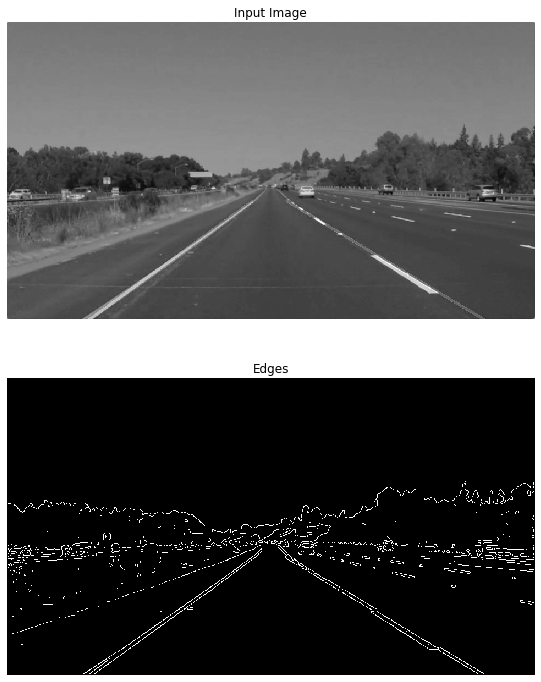

In [71]:
# Load image
img = io.imread('lane1.png', as_gray=True)

# Run Sobel edge detector
#edges_sobel = sobel(img)

# Run Canny edge detector
edges = canny(img, kernel_size=5, sigma=1.4, high=0.03, low=0.02)

plt.subplot(211)
plt.imshow(img)
plt.axis('off')
plt.title('Input Image')

plt.subplot(212)
plt.imshow(edges)
plt.axis('off')
plt.title('Edges')
plt.show()

### 2.2 Extracting region of interest (ROI)
We can see that the Canny edge detector could find the edges of the lanes. However, we can also see that there are edges of other objects that we are not interested in. Given the position and orientation of the camera, we know that the lanes will be located in the lower half of the image. The code below defines a binary mask for the ROI and extract the edges within the region.

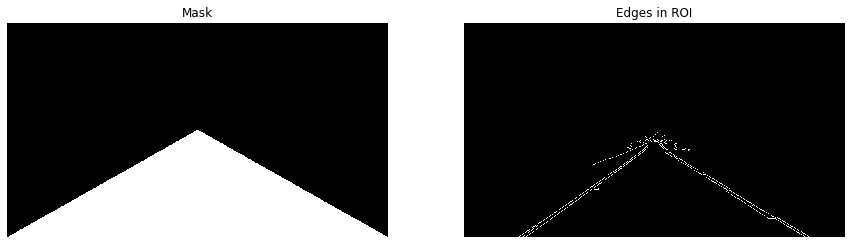

In [72]:
H, W = img.shape

# Generate mask for ROI (Region of Interest)
mask = np.zeros((H, W))
for i in range(H):
    for j in range(W):
        if i > (H / W) * j and i > -(H / W) * j + H:
            mask[i, j] = 1

# Extract edges in ROI
roi = edges * mask

plt.subplot(1,2,1)
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(roi)
plt.title('Edges in ROI')
plt.axis('off')
plt.show()

### 2.3 Fitting lines using Hough transform (50 points)
The output from the edge detector is still a collection of connected points. However, it would be more natural to represent a lane as a line parameterized as $y = ax + b$, with a slope $a$ and y-intercept $b$. We will use Hough transform to find parameterized lines that represent the detected edges.

In general, a straight line $y = ax + b$ can be represented as a point $(a, b)$ in the parameter space. However, this cannot represent vertical lines as the slope parameter will be unbounded. Alternatively, we parameterize a line using $\theta\in{[-\pi, \pi]}$ and $\rho\in{\mathbb{R}}$ as follows:

$$
\rho = x\cdot{cos\theta} + y\cdot{sin\theta}
$$

Using this parameterization, we can map everypoint in $xy$-space to a sine-like line in $\theta\rho$-space (or Hough space). We then accumulate the parameterized points in the Hough space and choose points (in Hough space) with highest accumulated values. A point in Hough space then can be transformed back into a line in $xy$-space.

*See [notes](http://web.ipac.caltech.edu/staff/fmasci/home/astro_refs/HoughTrans_lines_09.pdf) on Hough transform.*

Implement **`hough_transform`**.

In [73]:
def hough_transform(img):
    """ Transform points in the input image into Hough space.
    Use the parameterization:
        rho = x * cos(theta) + y * sin(theta)
    to transform a point (x,y) to a sine-like function in Hough space.
    Args:
        img: binary image of shape (H, W).
        
    Returns:
        accumulator: numpy array of shape (m, n).
        rhos: numpy array of shape (m, ).
        thetas: numpy array of shape (n, ).
    """
    # Set rho and theta ranges
    W, H = img.shape
    diag_len = int(np.ceil(np.sqrt(W * W + H * H)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2 + 1)
    thetas = np.deg2rad(np.arange(-90.0, 90.0))

    # Cache some reusable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Initialize accumulator in the Hough space
    accumulator = np.zeros((2 * diag_len + 1, num_thetas), dtype=np.uint64)
    ys, xs = np.nonzero(img)

    # Transform each point (x, y) in image
    # Find rho corresponding to values in thetas
    # and increment the accumulator in the corresponding coordiate.
    ### YOUR CODE HERE
    for y, x in zip(ys, xs):
        for t_idx, theta in enumerate(thetas):

            # Calculate the distance between the point (x, y) and the line with angle theta
            r = x * np.cos(theta) + y * np.sin(theta)
            rho = int(r + diag_len)

            # Increment the accumulator in the corresponding coordinate
            accumulator[rho, t_idx] += 1
    ### END YOUR CODE

    return accumulator, rhos, thetas

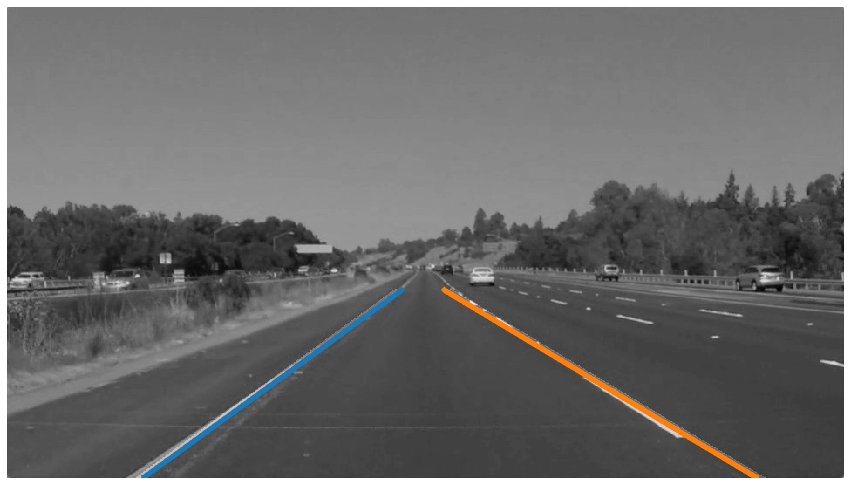

In [74]:
# Perform Hough transform on the ROI
acc, rhos, thetas = hough_transform(roi)

# Coordinates for right lane
xs_right = []
ys_right = []

# Coordinates for left lane
xs_left = []
ys_left = []

for i in range(20):
    idx = np.argmax(acc)
    r_idx = idx // acc.shape[1]
    t_idx = idx % acc.shape[1]
    acc[r_idx, t_idx] = 0 # Zero out the max value in accumulator

    rho = rhos[r_idx]
    theta = thetas[t_idx]
    
    # Transform a point in Hough space to a line in xy-space.
    a = - (np.cos(theta)/np.sin(theta)) # slope of the line
    b = (rho/np.sin(theta)) # y-intersect of the line

    # Break if both right and left lanes are detected
    if xs_right and xs_left:
        break
    
    if a < 0: # Left lane
        if xs_left:
            continue
        xs = xs_left
        ys = ys_left
    else: # Right Lane
        if xs_right:
            continue
        xs = xs_right
        ys = ys_right

    for x in range(img.shape[1]):
        y = a * x + b
        if y > img.shape[0] * 0.6 and y < img.shape[0]:
            xs.append(x)
            ys.append(int(round(y)))

plt.imshow(img)
plt.plot(xs_left, ys_left, linewidth=5.0)
plt.plot(xs_right, ys_right, linewidth=5.0)
plt.axis('off')
plt.show()